# Customer Segmentation and Pattern Discovery using Clustering Techniques

Goal: Analyze the dataset using exploratory data analysis (EDA) and apply clustering techniques (K-Means, Hierarchical, DBSCAN)

In [1]:
# Data handling
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & clustering
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE

# Utility
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset 
df = pd.read_csv("styles.csv", on_bad_lines='skip')

In [3]:
# Check the shape of the dataset
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (44424, 10)


In [4]:
# Display first 5 rows
display(df.head())

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
# Dataset information
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB
None


In [6]:
# Summary statistics for numeric columns
print("\nNumeric Columns Summary:")
display(df.describe())


Numeric Columns Summary:


,id,year
count,44424.000000,44423.000000
mean,29696.334301,2012.806497
std,17049.490518,2.126480
min,1163.000000,2007.000000
25%,14768.750000,2011.000000
50%,28618.500000,2012.000000
75%,44683.250000,2015.000000
max,60000.000000,2019.000000


In [7]:
# Summary for categorical columns
print("\nCategorical Columns Summary:")
display(df.describe(include=['object']))


Categorical Columns Summary:


,gender,masterCategory,subCategory,articleType,baseColour,season,usage,productDisplayName
count,44424,44424,44424,44424,44409,44403,44107,44417
unique,5,7,45,143,46,4,8,31121
top,Men,Apparel,Topwear,Tshirts,Black,Summer,Casual,Lucera Women Silver Earrings
freq,22147,21397,15402,7067,9728,21472,34406,82


# Data Cleaning

In [9]:
# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


In [10]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


In [11]:
# Remove rows with missing values
df = df.dropna()

# Verify missing values after cleaning
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())


Missing Values After Cleaning:
id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64


In [12]:
# Drop columns that don't help in clustering
df.drop(['id', 'productDisplayName'], axis=1, inplace=True)

In [13]:
# Verify the new columns
print("Remaining columns for clustering:")
print(df.columns)

Remaining columns for clustering:
Index(['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour',
       'season', 'year', 'usage'],
      dtype='object')


In [14]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [15]:
# Standardize text (lowercase, strip spaces)
for col in categorical_cols:
    df[col] = df[col].str.strip().str.lower()

In [16]:
df.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,men,apparel,topwear,shirts,navy blue,fall,2011.0,casual
1,men,apparel,bottomwear,jeans,blue,summer,2012.0,casual
2,women,accessories,watches,watches,silver,winter,2016.0,casual
3,men,apparel,bottomwear,track pants,black,fall,2011.0,casual
4,men,apparel,topwear,tshirts,grey,summer,2012.0,casual


In [17]:
# Unique Values in Categorical Features

cat_cols = df.select_dtypes(include=['object']).columns
print("\n Unique Values in Categorical Columns")
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(f"Values: {df[col].unique()}\n")


 Unique Values in Categorical Columns
gender: 5 unique values
Values: ['men' 'women' 'boys' 'girls' 'unisex']

masterCategory: 7 unique values
Values: ['apparel' 'accessories' 'footwear' 'personal care' 'free items'
 'sporting goods' 'home']

subCategory: 45 unique values
Values: ['topwear' 'bottomwear' 'watches' 'socks' 'shoes' 'belts' 'flip flops'
 'bags' 'innerwear' 'sandal' 'shoe accessories' 'fragrance' 'jewellery'
 'lips' 'saree' 'eyewear' 'scarves' 'dress' 'loungewear and nightwear'
 'wallets' 'apparel set' 'headwear' 'mufflers' 'skin care' 'makeup'
 'free gifts' 'ties' 'accessories' 'nails' 'beauty accessories'
 'water bottle' 'skin' 'eyes' 'bath and body' 'gloves'
 'sports accessories' 'cufflinks' 'sports equipment' 'stoles' 'hair'
 'perfumes' 'home furnishing' 'umbrellas' 'wristbands' 'vouchers']

articleType: 142 unique values
Values: ['shirts' 'jeans' 'watches' 'track pants' 'tshirts' 'socks' 'casual shoes'
 'belts' 'flip flops' 'handbags' 'tops' 'bra' 'sandals' 'shoe acce

# Exploratory Data Analysis

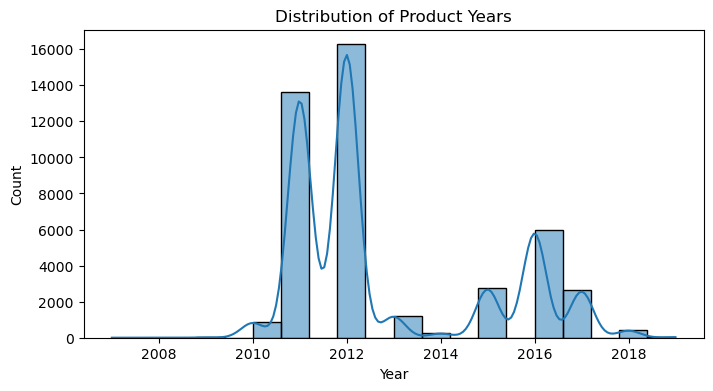

In [19]:
# Distribution of 'year'

plt.figure(figsize=(8,4))
sns.histplot(df['year'], bins=20, kde=True)
plt.title("Distribution of Product Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

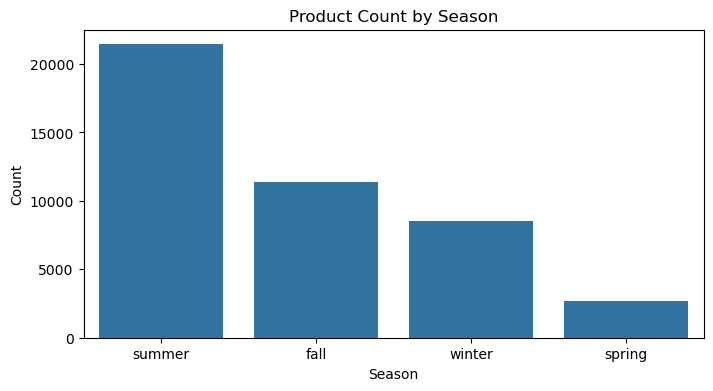

In [20]:
# Seasonal Trends

plt.figure(figsize=(8,4))
sns.countplot(x='season', data=df, order=df['season'].value_counts().index)
plt.title("Product Count by Season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.show()

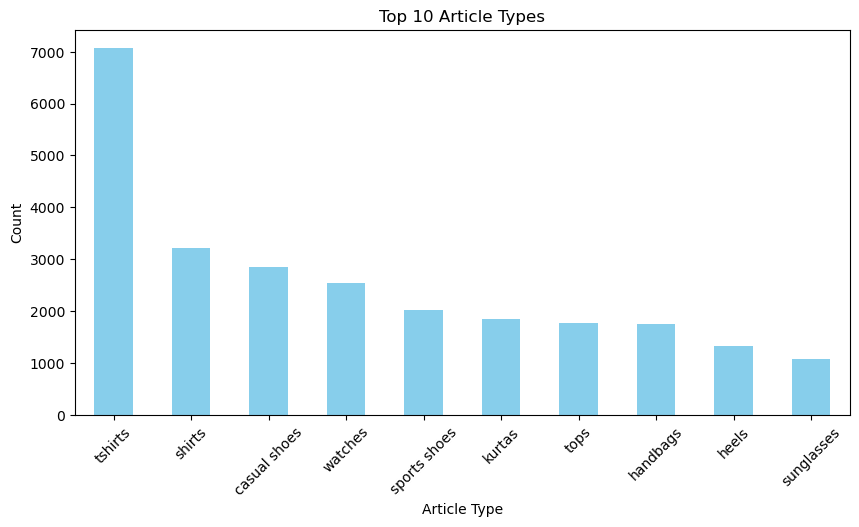

In [21]:
# Top 10 Article Types

plt.figure(figsize=(10,5))
df['articleType'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Article Types")
plt.xlabel("Article Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

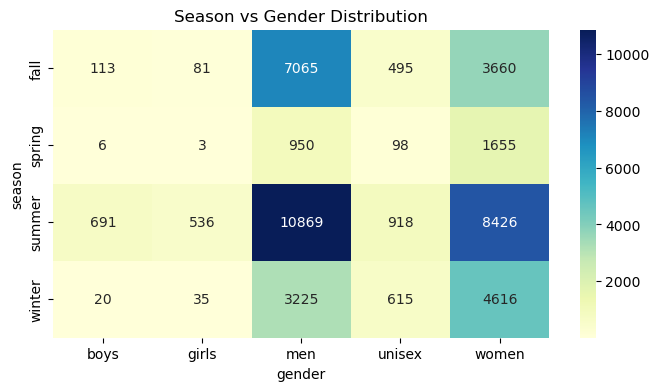

In [22]:
# Season vs Gender Heatmap

season_gender = pd.crosstab(df['season'], df['gender'])
plt.figure(figsize=(8,4))
sns.heatmap(season_gender, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Season vs Gender Distribution")
plt.show()

# Data Preprocessing

In [24]:
# Select categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  

# Fit and transform categorical data
encoded_array = encoder.fit_transform(df[cat_cols])

# Convert encoded array to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols))

# Combine with numerical columns
num_df = df.drop(columns=cat_cols)
df_encoded = pd.concat([num_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

print("Encoded dataset shape:", df_encoded.shape)
print(df_encoded.head())

Encoded dataset shape: (44077, 251)
     year  gender_girls  gender_men  gender_unisex  gender_women  \
0  2011.0           0.0         1.0            0.0           0.0   
1  2012.0           0.0         1.0            0.0           0.0   
2  2016.0           0.0         0.0            0.0           1.0   
3  2011.0           0.0         1.0            0.0           0.0   
4  2012.0           0.0         1.0            0.0           0.0   

   masterCategory_apparel  masterCategory_footwear  masterCategory_free items  \
0                     1.0                      0.0                        0.0   
1                     1.0                      0.0                        0.0   
2                     0.0                      0.0                        0.0   
3                     1.0                      0.0                        0.0   
4                     1.0                      0.0                        0.0   

   masterCategory_home  masterCategory_personal care  ...  season_sp

In [25]:
# Scale Numerical Columns

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()  # or MinMaxScaler()
scaled_array = scaler.fit_transform(df[num_cols])
scaled_df = pd.DataFrame(scaled_array, columns=num_cols)

In [26]:
# Combine Encoded + Scaled Features

df_final = pd.concat([scaled_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
print("Final dataset shape:", df_final.shape)
print(df_final.head())

Final dataset shape: (44077, 251)
       year  gender_girls  gender_men  gender_unisex  gender_women  \
0 -0.845332           0.0         1.0            0.0           0.0   
1 -0.370970           0.0         1.0            0.0           0.0   
2  1.526477           0.0         0.0            0.0           1.0   
3 -0.845332           0.0         1.0            0.0           0.0   
4 -0.370970           0.0         1.0            0.0           0.0   

   masterCategory_apparel  masterCategory_footwear  masterCategory_free items  \
0                     1.0                      0.0                        0.0   
1                     1.0                      0.0                        0.0   
2                     0.0                      0.0                        0.0   
3                     1.0                      0.0                        0.0   
4                     1.0                      0.0                        0.0   

   masterCategory_home  masterCategory_personal care  ... 

# Clustering

In [28]:
# KMeans 
X = df_final.select_dtypes(include=['float64','int64'])

inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    sil = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(sil)

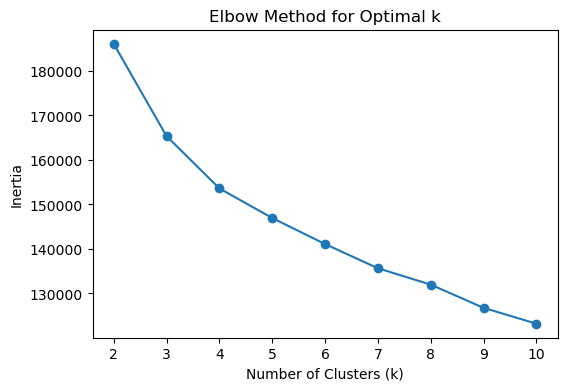

In [29]:
# Elbow Method Plot
plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

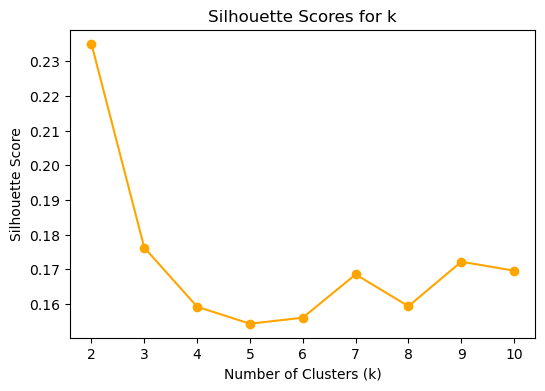

In [30]:
# Silhouette Score Plot
plt.figure(figsize=(6,4))
plt.plot(K, silhouette_scores, marker="o", color="orange")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for k")
plt.show()

In [31]:
# Best k from silhouette
best_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Best k (by silhouette): {best_k}")

Best k (by silhouette): 2


In [32]:
# Final KMeans 
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["kmeans_cluster"] = kmeans.fit_predict(X)

print(df[["kmeans_cluster"]].head())

   kmeans_cluster
0               0
1               0
2               1
3               0
4               0


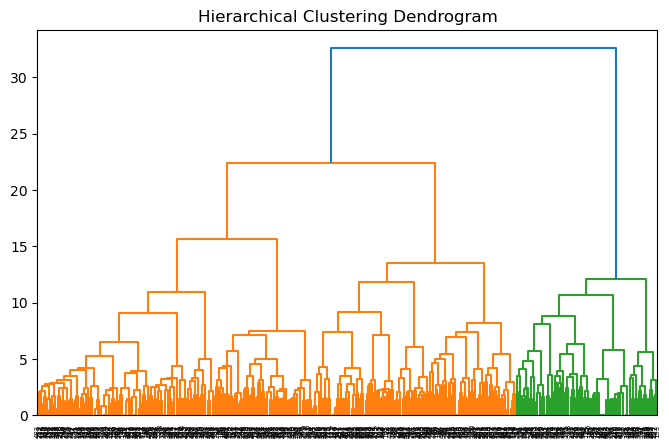

In [33]:
# Hierarchical Clustering

plt.figure(figsize=(8,5))
linked = linkage(X.sample(500, random_state=42), method='ward')  # sample for speed
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [34]:
# DBSCAN Clustering

dbscan = DBSCAN(eps=1.5, min_samples=5)  # tune eps & min_samples
df["dbscan_cluster"] = dbscan.fit_predict(X)

print("DBSCAN cluster labels:", df["dbscan_cluster"].value_counts())

DBSCAN cluster labels: dbscan_cluster
 0     15855
 3      9189
 2      8922
 1      3110
 4      1787
 9      1070
 6      1012
 5      1006
 8       426
 7       414
 16      278
 18      275
-1       129
 12      102
 10       94
 23       87
 14       66
 11       64
 25       19
 20       18
 15       18
 22       17
 13       13
 29       12
 19       10
 28       10
 27        9
 31        9
 21        8
 30        8
 34        6
 33        6
 17        6
 26        6
 35        6
 32        5
 24        5
Name: count, dtype: int64


# Model Training and Evalution

In [36]:
# Use only numeric features
X = df.select_dtypes(include=[np.number])

# Define Evaluation Function

def evaluate_clustering(X, labels, algo_name):
    """Return metrics for clustering evaluation."""
    # Ignore metrics if only 1 cluster
    if len(set(labels)) <= 1:
        return {
            "Algorithm": algo_name,
            "Silhouette": np.nan,
            "DaviesBouldin": np.nan,
            "CalinskiHarabasz": np.nan
        }
    return {
        "Algorithm": algo_name,
        "Silhouette": silhouette_score(X, labels),
        "DaviesBouldin": davies_bouldin_score(X, labels),
        "CalinskiHarabasz": calinski_harabasz_score(X, labels)
    }

results = []

In [37]:
# KMeans

best_k = 2  
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)
results.append(evaluate_clustering(X, labels_kmeans, f"KMeans (k={best_k})"))

In [38]:
# Hierarchical Clustering

hier = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
labels_hier = hier.fit_predict(X)
results.append(evaluate_clustering(X, labels_hier, f"Hierarchical (k={best_k})"))

In [39]:
# 3. DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)  # tune hyperparams
labels_dbscan = dbscan.fit_predict(X)
results.append(evaluate_clustering(X, labels_dbscan, "DBSCAN"))

In [40]:
# Compare Results

results_df = pd.DataFrame(results)
print("\n Clustering Evaluation Results:")
print(results_df)

# Save with cluster labels for later use
df["kmeans_cluster"] = labels_kmeans
df["hier_cluster"] = labels_hier
df["dbscan_cluster"] = labels_dbscan
print(" Saved clustered dataset with evaluation metrics.")


 Clustering Evaluation Results:
            Algorithm  Silhouette  DaviesBouldin  CalinskiHarabasz
0        KMeans (k=2)    0.599820       0.835128      37296.691033
1  Hierarchical (k=2)    0.582274       0.878097      34942.500007
2              DBSCAN    0.389869       0.722274       3014.011067
 Saved clustered dataset with evaluation metrics.


In [41]:
df.columns

Index(['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour',
       'season', 'year', 'usage', 'kmeans_cluster', 'dbscan_cluster',
       'hier_cluster'],
      dtype='object')

# visualization

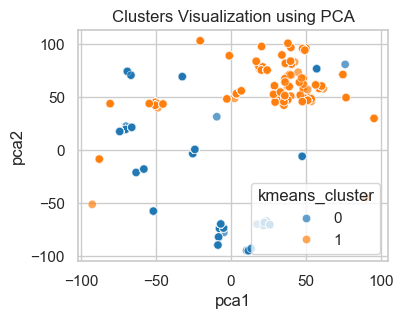

In [84]:
sns.set(style="whitegrid", palette="Set2")

# Numeric features only
X = df.select_dtypes(include=["number"])

# PCA Visualization (2D)

pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X)

df["pca1"] = pca_coords[:, 0]
df["pca2"] = pca_coords[:, 1]

plt.figure(figsize=(4, 3))
sns.scatterplot(x="pca1", y="pca2", hue="kmeans_cluster", data=df,
                palette="tab10", alpha=0.7)
plt.title("Clusters Visualization using PCA")
plt.show()

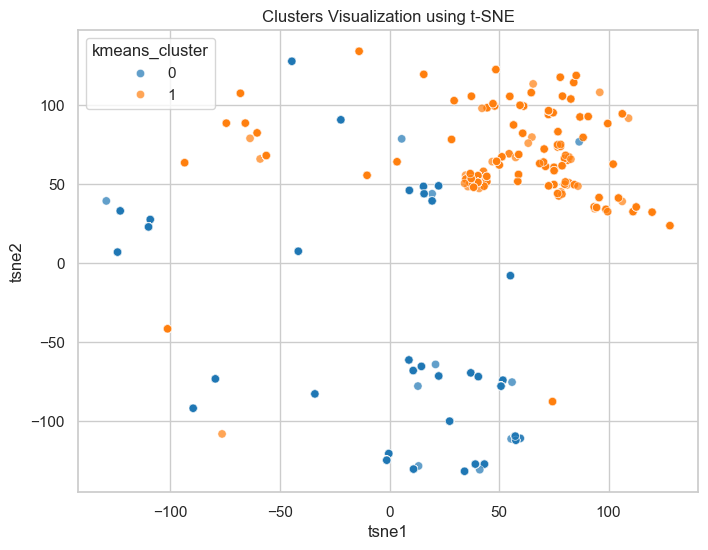

In [86]:
# t-SNE Visualization 

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,
            random_state=42, init="pca")
tsne_coords = tsne.fit_transform(X)

df["tsne1"] = tsne_coords[:, 0]
df["tsne2"] = tsne_coords[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="tsne1", y="tsne2", hue="kmeans_cluster", data=df,
                palette="tab10", alpha=0.7)
plt.title("Clusters Visualization using t-SNE")
plt.show()

# Deployment

In [94]:
df_with_clusters = df.copy()
df_with_clusters["Cluster"] = labels_kmeans  # replace with labels from chosen algorithm

# Save as CSV and Excel
df_with_clusters.to_csv("clustered_data_with_labels.csv", index=False)

print(" Clustered dataset saved successfully!")

 Clustered dataset saved successfully!


# Conclusion
* Through comprehensive exploratory data analysis and the application of multiple clustering algorithms (K-Means, Hierarchical, DBSCAN), the dataset was successfully segmented into meaningful groups. The evaluation metrics, including Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index, confirmed the quality and separation of the clusters. Visualization techniques such as PCA, t-SNE helped in interpreting the feature patterns within each cluster.
* These insights can be directly applied to build recommendation systems, enhance targeted marketing campaigns, and optimize decision-making strategies. The clustering process not only revealed hidden structures in the data but also provided a scalable framework for future analysis as new data becomes available.